In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib
import math

sns.set_theme()

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# Load data
df = pd.read_csv("ABBV.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,79.769997,80.849998,79.279999,80.099998,62.999916,8567900
1,2019-03-04,80.400002,80.730003,79.110001,79.459999,62.496536,5872500
2,2019-03-05,79.379997,79.900002,78.720001,78.910004,62.063972,5933100
3,2019-03-06,79.129997,79.129997,77.559998,78.089996,61.419022,5293200
4,2019-03-07,77.769997,79.120003,77.440002,78.239998,61.536999,6642500
...,...,...,...,...,...,...,...
1318,2024-05-24,158.360001,158.779999,156.360001,157.059998,157.059998,3689900
1319,2024-05-28,156.350006,156.350006,153.949997,155.339996,155.339996,5533500
1320,2024-05-29,154.889999,156.380005,153.679993,154.789993,154.789993,4254500
1321,2024-05-30,154.649994,156.429993,153.580002,156.309998,156.309998,4311100


In [ ]:
# Define train and test size
train_size = int(len(df) * 0.6)
train, test = df[:train_size+20], df[train_size:]

# Define features and target
features = [col for col in df.columns if col not in ['Date', 'Close']]
target = 'Close'

# Preprocess data for LightGBM
X_train_lgb, y_train_lgb = train[features], train[target]
X_test_lgb, y_test_lgb = test[features], test[target]

train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)
test_data = lgb.Dataset(X_test_lgb, label=y_test_lgb)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 30,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model_lgb = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=10000)

y_pred = model_lgb.predict(X_test_lgb, num_iteration=model_lgb.best_iteration)
rmse = np.sqrt(mean_squared_error(y_test_lgb, y_pred))
print(f'Root Mean Squared Error: {rmse}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 813, number of used features: 5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 101.085473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
import joblib
# save model
joblib.dump(model_lgb, 'lgb_ABBV.pkl')

['lgb_ABBV.pkl']

In [ ]:
# Preprocess data for LSTM
close_df = df[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
close_dfY = df[['Close']]

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(close_df))
print(closedf)

[[0.13665013 0.13999157 0.14208067 0.09302628 0.08100328]
 [0.14194473 0.13898023 0.14063695 0.08913792 0.05063367]
 [0.13337254 0.13198486 0.13732485 0.08579658 0.05131646]
 ...
 [0.76796369 0.7765698  0.77392774 0.80205883 0.03240334]
 [0.76594667 0.7769911  0.77307856 0.81380011 0.03304106]
 [0.78275481 0.82090181 0.79532904 0.85188196 0.16096096]]


In [ ]:
scalery=MinMaxScaler(feature_range=(0,1))
closedfY=scalery.fit_transform(np.array(close_dfY))
print(closedfY)

[[0.14372059]
 [0.13834787]
 [0.13373072]
 ...
 [0.7707353 ]
 [0.78349558]
 [0.82488247]]


In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size+21,:],closedf[training_size+19:len(closedf),:]
train_datay,test_datay=closedfY[0:training_size+21,:],closedfY[training_size+19:len(closedf),:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)
print("train_data: ", train_datay.shape)
print("test_data: ", test_datay.shape)

train_data:  (814, 5)
test_data:  (511, 5)
train_data:  (814, 1)
test_data:  (511, 1)


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(y[i + time_step]) # 0
    return np.array(dataX), np.array(dataY)

time_step = 20
X_train, y_train = create_dataset(train_data, train_datay, time_step)
X_test, y_test = create_dataset(test_data, test_datay, time_step)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 5) #1 is the number of features
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 5) #1 is the number of features

print(X_train.shape)
print(y_train.shape)

(793, 20, 5)
(793, 1)


In [ ]:
# Build and train the LSTM model
model=Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(time_step, 5)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            4864      
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21537 (84.13 KB)
Trainable params: 21537 (84.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
25/25 [==============================] - 9s 82ms/step - loss: 0.0297 - val_loss: 0.0171
Epoch 2/20
25/25 [==============================] - 1s 32ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 3/20
25/25 [==============================] - 1s 30ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 4/20
25/25 [==============================] - 1s 32ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 5/20
25/25 [==============================] - 1s 31ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 6/20
25/25 [==============================] - 1s 30ms/step - loss: 0.0030 - val_loss: 0.0054
Epoch 7/20
25/25 [==============================] - 1s 29ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 8/20
25/25 [==============================] - 1s 41ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/20
25/25 [==============================] - 1s 48ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 10/20
25/25 [==============================] - 1s 54ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 11/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


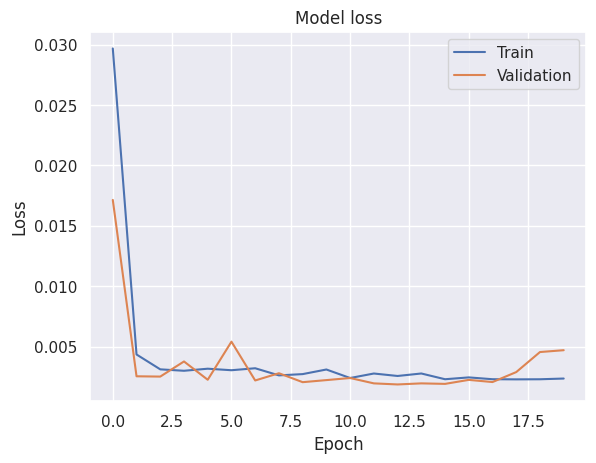

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32,verbose=1)
model.save("lstm_abbv_real.h5")

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

# Transform back to original form
train_predict = scalery.inverse_transform(train_predict)
test_predict = scalery.inverse_transform(test_predict)
original_ytrain = scalery.inverse_transform(y_train.reshape(-1,1))
original_ytest = scalery.inverse_transform(y_test.reshape(-1,1))

# Combine train and test predictions for plotting
combined_predictions = np.concatenate((train_predict, test_predict))
combined_actual = np.concatenate((original_ytrain, original_ytest))

16/16 [==============================] - 0s 12ms/step


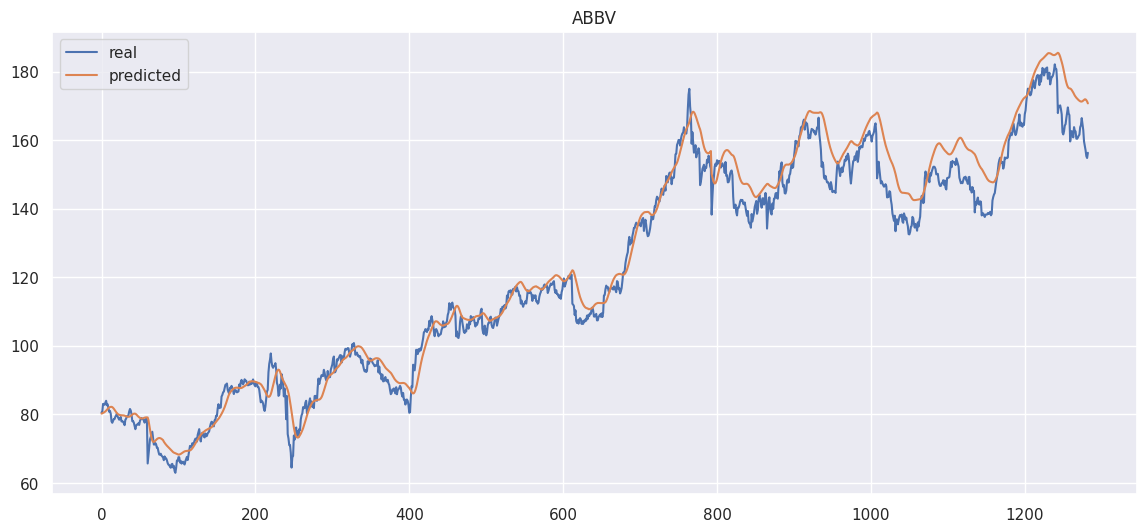

In [ ]:
plt.figure(figsize = (14,6))
plt.title("ABBV")
plt.plot(combined_actual, label = "real")
plt.plot(combined_predictions, label = 'predicted')
plt.legend()

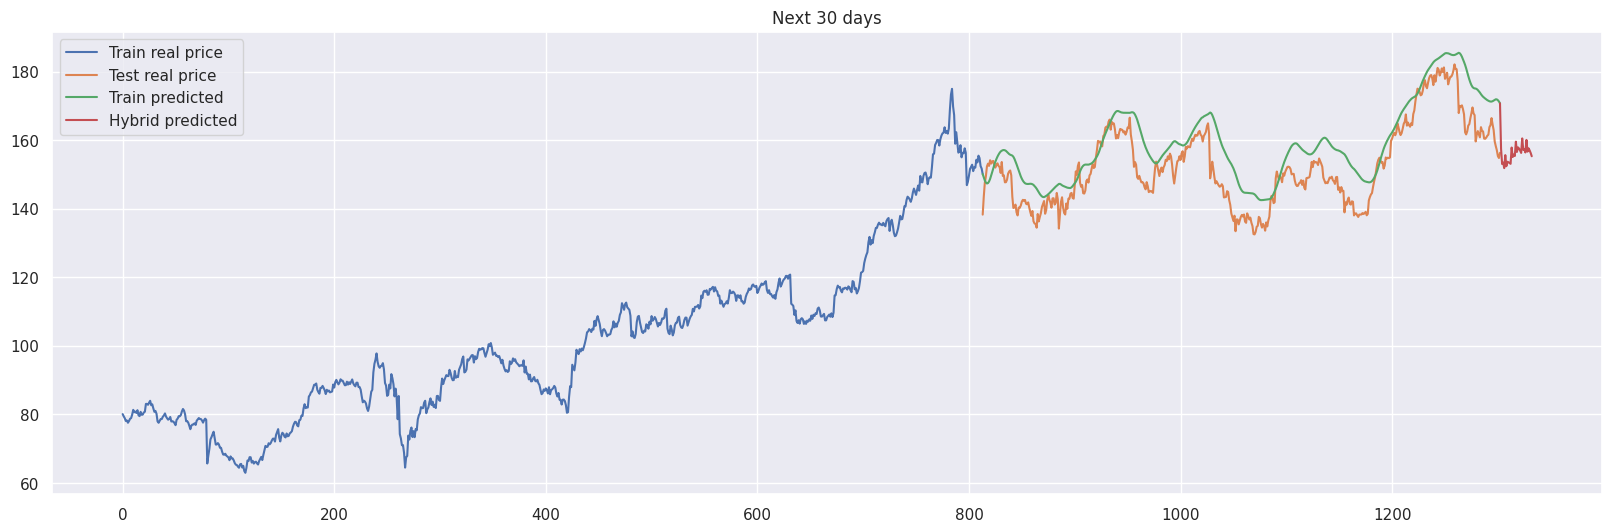

In [ ]:
features = [col for col in df.columns if col not in ['Date', 'Adj Close']]
last_known_features = df[features].iloc[-1].values.reshape(1, -1)
day = 30

future_predictions = []
for i in range(day):
    next_pred = model_lgb.predict(last_known_features)
    future_predictions.append(next_pred[0])

    # Update last_known_features with the new prediction
    new_row = np.append(next_pred, last_known_features[0, :-1])
    last_known_features = new_row.reshape(1, -1)

# real = test["Close"].values
trainr = train["Close"].values
trainr = np.append(trainr, test_predict[0])
avg = [list(test_predict.flatten())[-1]] + [(i+j)/2 for i,j in zip(future_predictions, test_predict[:day].flatten())]

days = list(df.iloc[training_size+20:len(df)-20].index)
next_days = np.arange(days[-1], days[-1]+day+1)

plt.figure(figsize = (20,6))
plt.title(f"Next {day} days")

plt.plot(trainr, label = "Train real price")
plt.plot(days, original_ytest, label = "Test real price")
plt.plot(days, test_predict, label = 'Train predicted')
# plt.plot(next_days, future_predictions, label = "Predicted price")
plt.plot(next_days, avg, label = 'Hybrid predicted')
plt.legend()

In [ ]:
len([list(test_predict.flatten())[-1]]+[(i+j)/2 for i,j in zip(future_predictions, test_predict[:day].flatten())])

31

In [ ]:
import math

print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
# print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("Train data MAPE: ", mean_absolute_error(original_ytrain,train_predict)/len(original_ytrain))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
# print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("Train data MAPE: ", mean_absolute_error(original_ytest,test_predict)/len(original_ytest))

Train data RMSE:  4.013361962437563
Train data MAE:  3.0054080352997175
Train data MAPE:  0.0037899218604031744
-------------------------------------------------------------------------------------
Test data RMSE:  8.161327331609549
Test data MAE:  6.873839116316566
Train data MAPE:  0.014028243094523605


In [ ]:
# print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
# print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

In [ ]:
# print("Train data R2 score:", r2_score(original_ytrain, train_predict))
# print("Test data R2 score:", r2_score(original_ytest, test_predict))

In [ ]:
# print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
# print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
# print("----------------------------------------------------------------------")
# print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
# print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))